In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import xarray as xr
import torch
from torch_geometric.data import Data, Dataset
from Trainer_loocv import Trainer
from utils import get_distance, draw_graph, nearest_neighbors_graph, plot_heatmap, dataset_generation
from GCN_Regression import GCN_RegressionModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data/final_data_mar.csv.gz')
df['time'] = pd.to_datetime(df['time'])

/Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops6narrow4callERKNS_6TensorExxx
  Referenced from: <C81444D6-28AA-3518-9469-CCF13C702377> /Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <59ED1CF5-3CD8-3592-A70B-3AB98E4C5F21> /Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch_geometric/typing.py:41: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Users/mihiragarwal/mambaforge/envs/

OSError: dlopen(/Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch_cluster/_grid_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops6narrow4callERKNS_6TensorExxx
  Referenced from: <CC09D83A-B025-3AEF-9C6F-5B4B8BA990AA> /Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch_cluster/_grid_cpu.so
  Expected in:     <59ED1CF5-3CD8-3592-A70B-3AB98E4C5F21> /Users/mihiragarwal/mambaforge/envs/srip/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib

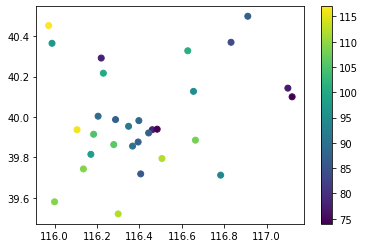

In [2]:
temp = df[df['time'] == '2014-05-01 00:00:00']
plt.scatter(temp['longitude'], temp['latitude'], c = temp['PM25_Concentration'])
plt.colorbar();

In [3]:
def loocv(timestamp):
    dataframe = []
    d = df[df["time"]==timestamp]
    G = nearest_neighbors_graph(d, 8)
    node_features, edge_index, y = dataset_generation(G)
    
    for super in list(G.nodes()):
#         print(super)
        # Divide train and test masks based on the latitudes
        train_mask = torch.zeros(y.size(0), dtype=torch.bool)
        test_mask = torch.zeros(y.size(0), dtype=torch.bool)
        for j, node in list(enumerate(G.nodes)):
            if node!=super:
                train_mask[j] = True
            else:
                test_mask[j] = True
        
        data = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, y=y,train_mask=train_mask, test_mask = test_mask)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = GCN_RegressionModel(2)
        trainer = Trainer(model = model, data = data, device = device, epochs=2500)
        trainer.train(lr=0.001)
        out = model(data.x.to(device), data.edge_index.to(device))  # Predicted PM values
        gnn_pred = out[data.test_mask].squeeze().tolist()
        gnn_rmse = torch.sqrt(torch.mean((out[data.test_mask].squeeze() - data.y[data.test_mask].squeeze())**2))
        
        actual = data.y[data.test_mask].squeeze().tolist()
        
        X_train = data.x[data.train_mask].numpy()
        y_train = data.y[data.train_mask].numpy().reshape(-1)
        X_test = data.x[data.test_mask].numpy()
        y_test = data.y[data.test_mask].numpy().reshape(-1)
        
        #RF
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        rf_rmse = torch.sqrt(torch.mean((torch.tensor(rf_pred) - data.y[data.test_mask])**2))
        
        #KNN
        knn_model = KNeighborsRegressor(n_neighbors = 8)
        knn_model.fit(X_train, y_train)
        knn_pred = knn_model.predict(X_test)
        knn_rmse = torch.sqrt(torch.mean((torch.tensor(knn_pred) - data.y[data.test_mask])**2))
        
        #LR
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        lr_rmse = torch.sqrt(torch.mean((torch.tensor(lr_pred) - data.y[data.test_mask])**2))
        
        #idw
        idw_model = KNeighborsRegressor(n_neighbors = 8, weights = 'distance')
        idw_model.fit(X_train, y_train)
        idw_pred = idw_model.predict(X_test)
        idw_rmse = torch.sqrt(torch.mean((torch.tensor(idw_pred) - data.y[data.test_mask])**2))
        
        #Mean
        train_mean = torch.mean(data.y[data.train_mask])
        mean_pred = int(data.test_mask.sum())*[float(train_mean)]
        mean_rmse = torch.sqrt(torch.mean((train_mean - data.y[data.test_mask].squeeze())**2))
        
        dataframe.append({
                            "node": G.nodes[super]["station"],
                            "lat": G.nodes[super]["latitude"],
                            "lon": G.nodes[super]["longitude"],
                            "pm": G.nodes[super]["pm"],
                            "knn rmse": float(knn_rmse),
                            "mean rmse": float(mean_rmse),
                            "idw rmse": float(idw_rmse),
                            "lr rmse": float(lr_rmse),
                            "rf rmse": float(rf_rmse),
                            "gnn rmse": float(gnn_rmse),
                            "actual": actual,
                            "knn pred": knn_pred[0],
                            "mean pred": mean_pred[0],
                            "idw pred": idw_pred[0],
                            "lr pred": lr_pred[0],
                            "rf pred": rf_pred[0],
                            "gnn pred": gnn_pred,    
                           })
    
    return dataframe

KNN RMSE:  9.934348424275717
Mean RMSE:  11.97001584370931
IDW RMSE:  8.659398982310018
RF RMSE:  8.385144539006552
LR RMSE:  9.237105178833009
GNN RMSE:  11.613720575968424


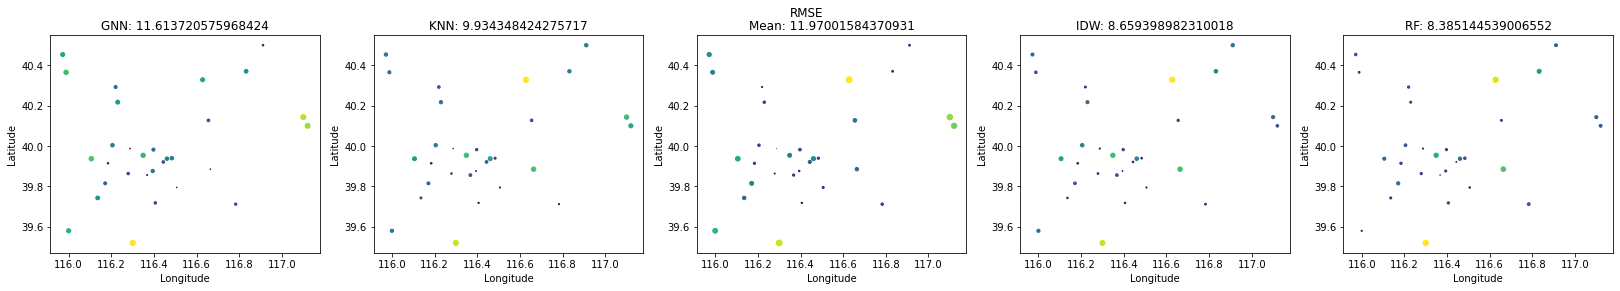

KNN RMSE:  18.56720733642578
Mean RMSE:  19.74689687093099
IDW RMSE:  17.542485349208455
RF RMSE:  16.35365783030192
LR RMSE:  16.853600565592448
GNN RMSE:  19.966241073608398


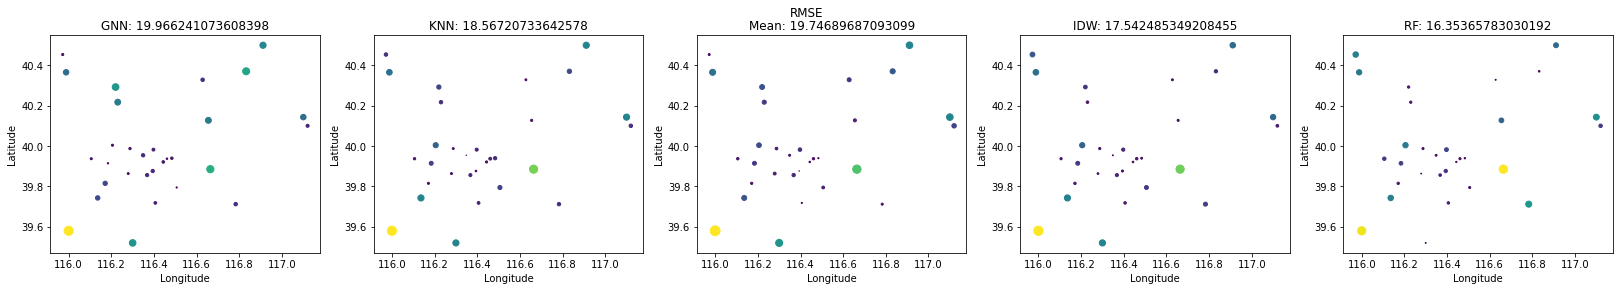

KNN RMSE:  29.87850850423177
Mean RMSE:  30.42516632080078
IDW RMSE:  30.38761338837169
RF RMSE:  27.008369921875
LR RMSE:  33.4272715250651
GNN RMSE:  32.41409708658854


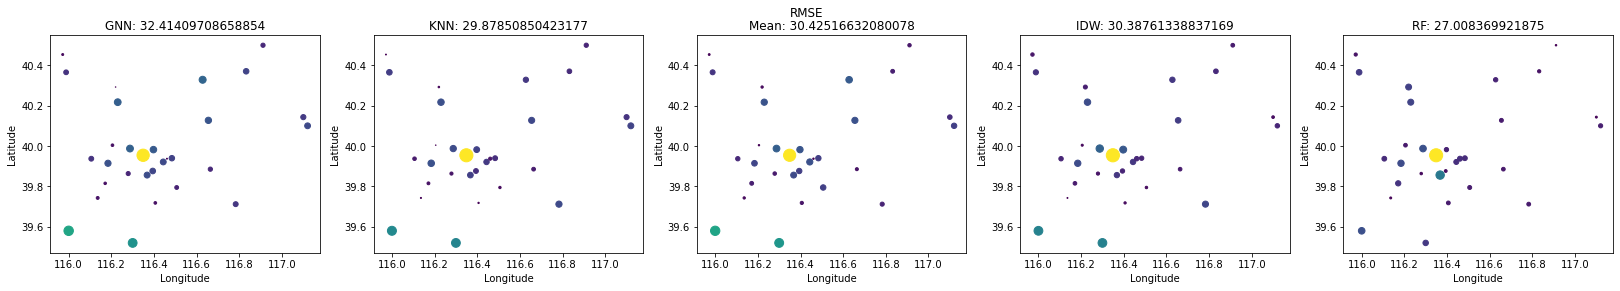

KNN RMSE:  25.675
Mean RMSE:  31.022989400227864
IDW RMSE:  20.84647834106683
RF RMSE:  21.531499999999998
LR RMSE:  26.628887176513672
GNN RMSE:  34.41682459513346


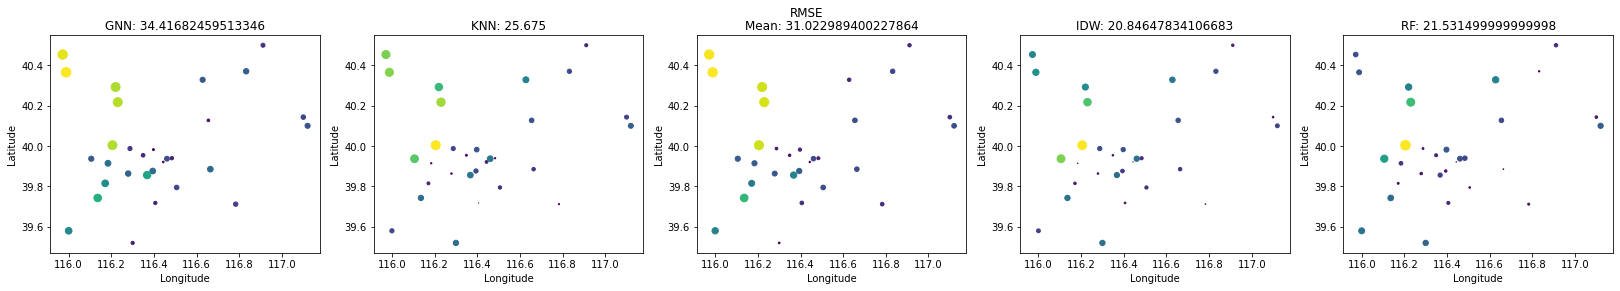

KNN RMSE:  6.734027735392252
Mean RMSE:  7.305746714274089
IDW RMSE:  5.674041754046228
RF RMSE:  6.140194590663909
LR RMSE:  7.243301073710124
GNN RMSE:  7.448266728719076


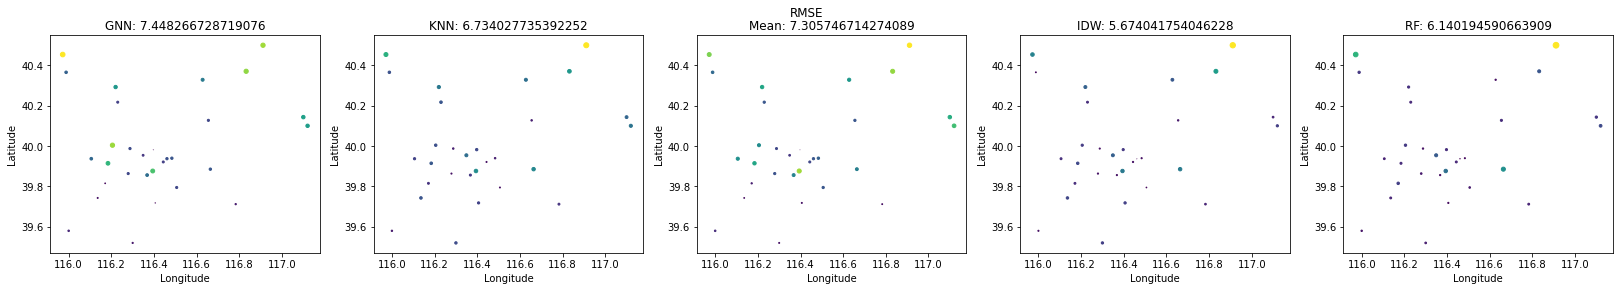

KNN RMSE:  26.540350596110027
Mean RMSE:  35.54973780314128
IDW RMSE:  25.30512315912318
RF RMSE:  25.640478521474204
LR RMSE:  26.33540267944336
GNN RMSE:  37.63226140340169


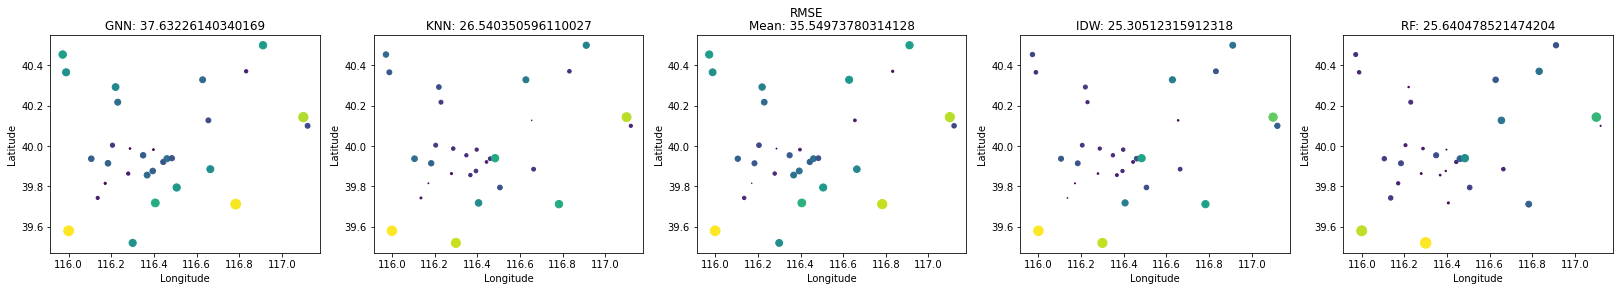

KNN RMSE:  33.28333333333333
Mean RMSE:  30.400000508626302
IDW RMSE:  33.31851755038795
RF RMSE:  33.88073333333334
LR RMSE:  30.501302083333332
GNN RMSE:  32.76878662109375


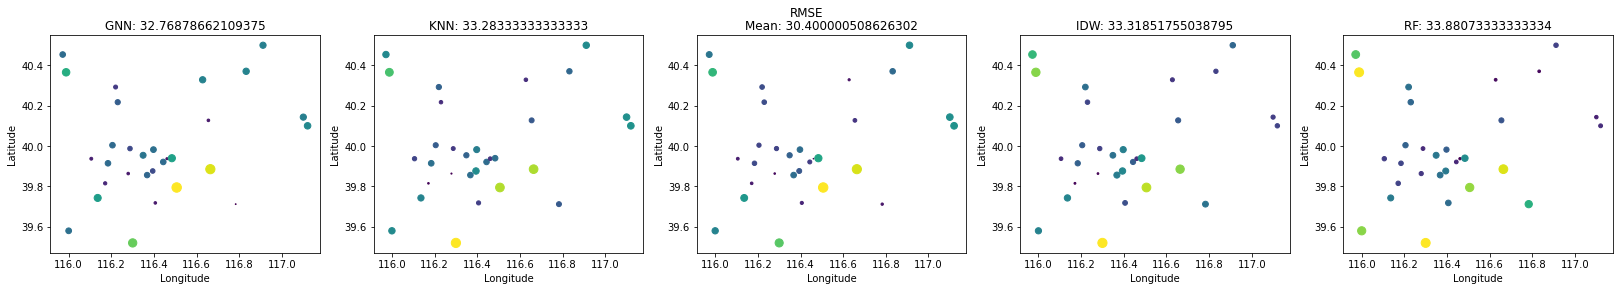

In [4]:
p = pd.date_range(start='2014-05-01 00:00:00', end='2014-12-01 00:00:00', freq = '1M').to_frame(name='dates')

for i in p['dates']:
    d_i = loocv(i)
    d_i = pd.DataFrame(d_i)
    print('KNN RMSE: ', np.mean(d_i['knn rmse']))
    print('Mean RMSE: ', np.mean(d_i['mean rmse']))
    print('IDW RMSE: ', np.mean(d_i['idw rmse']))
    print('RF RMSE: ', np.mean(d_i['rf rmse']))
    print('LR RMSE: ', np.mean(d_i['lr rmse']))
    print('GNN RMSE: ', np.mean(d_i['gnn rmse']))
    
    plt.figure(figsize = (28,4))
    plt.suptitle('RMSE')
    plt.subplot(1, 5, 1)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['gnn rmse'], c = d_i['gnn rmse'])
    title = 'GNN: ' + str(np.mean(d_i['gnn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 2)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['knn rmse'], c = d_i['knn rmse'])
    title = 'KNN: ' + str(np.mean(d_i['knn rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 3)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['mean rmse'], c = d_i['mean rmse'])
    title = 'Mean: ' + str(np.mean(d_i['mean rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 4)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['idw rmse'], c = d_i['idw rmse'])
    title = 'IDW: ' + str(np.mean(d_i['idw rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.subplot(1, 5, 5)
    plt.scatter(d_i['lon'], d_i['lat'],  s = d_i['rf rmse'], c = d_i['rf rmse'])
    title = 'RF: ' + str(np.mean(d_i['rf rmse']))
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [5]:
p

,dates
2014-05-31,2014-05-31
2014-06-30,2014-06-30
2014-07-31,2014-07-31
2014-08-31,2014-08-31
2014-09-30,2014-09-30
2014-10-31,2014-10-31
2014-11-30,2014-11-30
